<a href="https://colab.research.google.com/github/cjk5642/Connector/blob/main/paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Imports

In [30]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

from nltk.stem import PorterStemmer
ps = PorterStemmer()

plot_path = "/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Plots"

# Load Data

In [3]:
def cosine_similarity(v1, v2):
  v1 = np.array(v1)
  v2 = np.array(v2)
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def return_emb(word, source = 'glove'):
  if source == 'glove':
    source_emb = glove
  else:
    source_emb = swow
    
  try:
    emb = source_emb[word]
    return word
  except KeyError:
    word_stem = ps.stem(word)
    try:
      emb = source_emb[word_stem]
      return word_stem
    except KeyError:
      return np.NaN

def return_clue(data):
  values = []
  options = ['clueOption1', 'clueOption2', 'clueOption3', 'clueOption4', 'clueOption5', 'clueOption6', 'clueOption7', 'clueOption8']
  for i in range(len(data)):
    row = data.loc[i, options].dropna().to_list()
    try:
      option = row.index(data.loc[i, 'clueFinal'])
      values.append(int(options[option].lstrip('clueOption')))
    except ValueError:
      values.append(None)
  return values

def return_guess(data):
  values = {'GUESS_1_FINAL': [], 'GUESS_2_FINAL': []}
  options = ['GuessOption1', 'GuessOption2', 'GuessOption3', 'GuessOption4', 'GuessOption5', 'GuessOption6', 'GuessOption7', 'GuessOption8']
  guesses = ['GUESS_1_FINAL', 'GUESS_2_FINAL']
  for i in range(len(data)):
    row = data.loc[i, options].dropna().to_list()
    finals = data.loc[i, guesses]
    for f in guesses:
      try:
        option = row.index(finals[f])
        values[f].append(int(options[option].lstrip('GuessOption')))
      except ValueError:
        values[f].append(None)
  return values.values()

rankings = {'Easy': 1, 'Medium': 2, 'Hard': 3}
wordpairs_path = "/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/wordpairs.csv"
wordpairs = pd.read_csv(wordpairs_path)

In [4]:
wordpairs.head()

,wordpair,wordpair_id,Level
0,ankle-travel,ankle-travel,medium
1,travel-ankle,ankle-travel,medium
2,army-drum,army-drum,medium
3,drum-army,army-drum,medium
4,ash-snake,ash-snake,hard


In [5]:
#raw_path = parentdirectory + "raw_data.csv"
############# Extract Raw
raw_path = "/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/raw_data.csv"
raw = pd.read_csv(raw_path, usecols = ['Experiment', 'Word1', 'Word2', 'Clue1', 'Level', 'Player2.ACC', 'Clue2', 'Clue3'])
raw['Word Pair'] = raw['Word1'] + '-' + raw['Word2']
raw = raw[raw['Word Pair'].isin(wordpairs['wordpair'].to_list())].reset_index(drop = True)
raw['wordpair_id'] = [wordpairs.loc[wordpairs['wordpair'] == raw.loc[i, 'Word Pair'], 'wordpair_id'].values[0] for i in range(len(raw))]
raw_clues = raw.loc[:, ['wordpair_id', 'Clue1', 'Clue2', 'Clue3', 'Player2.ACC']]

raw_temp = raw.rename({'Word1': 'target1', 'Word2': 'target2'}, axis = 1)

In [6]:
#parentdirectory = "/content/drive/My Drive/connector-collin/"
#online_path = parentdirectory + "connector-online-data.csv"
########### Extract Online
online_path = "/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/online.csv"

online = pd.read_csv(online_path)
online['Ranking'] = online['Level'].apply(lambda x: rankings[x])
online_clues = online.loc[:, ['wordpair_id', 'gameID', 'clueOption1', 'clueOption2', 'clueOption3', 'clueOption4', 'clueOption5', 'clueOption6', 'clueOption7', 'clueOption8', 'clueFinal', 'Acc', 'Level', 'Ranking']]
online_unique_clues = online_clues[['clueOption1', 'clueOption2', 'clueOption3', 'clueOption4', 'clueOption5', 'clueOption6', 'clueOption7', 'clueOption8']]
online_clues['Number of Clues'] = [len(online_unique_clues.loc[i,:].dropna().to_list()) for i in range(len(online_clues))]
online.to_csv(r"/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/Processed/online.csv", index = False)

In [7]:
#glove_path = parentdirectory + "glove_embeddings.csv"
glove_path = "/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/glove_embeddings.csv"
glove = pd.read_csv(glove_path)

In [8]:
swow_path = "/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/swow_embeddings.csv"
swow = pd.read_csv(swow_path)

#*Searching for multiple concepts within semantic memory*

Collin J. Kovacs, Jasper M. Wilson, and Abhilasha A. Kumar

[Latex paper draft](https://www.overleaf.com/3682451699jnphdztfwskz)

There is not a lot of work investigating the explicit search processes in ambiguous multi-referent contexts. Previous work in this area has shown that speakers tend to use some form of context sensitivity judgment and pragmatic inference to come up with the final response, BUT the explicit generation process remains obscure in these communication tasks. How might we study this process by which an individual arrives upon the final referent? In this work, we introduce and evaluate a think-aloud paradigm for capturing interim responses during semantic search, borrowing from tasks such as fluency and variants of RAT. (explain task)

##- We discuss whether and how it differs from the standard paradigm. 
  - Average accuracy in easy/medium/hard for both datasets

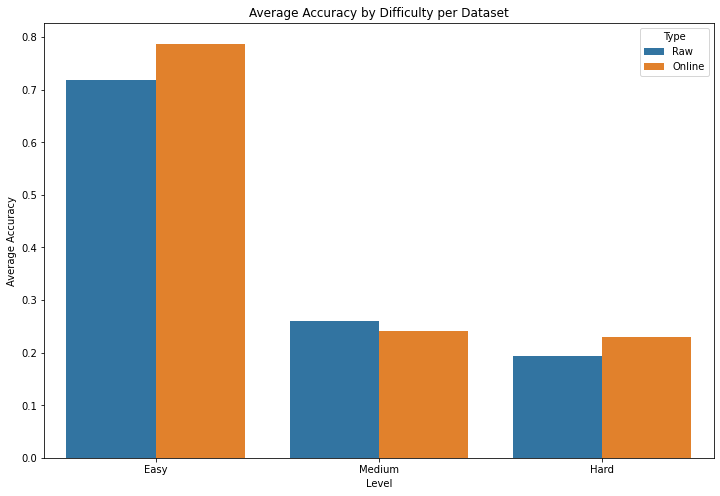

In [31]:
avg_acc_level_raw = raw.groupby('Level').mean().reset_index().rename({'Player2.ACC': 'Average Accuracy'}, axis = 1)
avg_acc_level_raw['Type'] = 'Raw'
avg_acc_level_online = online[['Level', 'Acc']].groupby('Level').mean().reset_index().rename({'Acc': 'Average Accuracy'}, axis = 1)
avg_acc_level_online['Type'] = 'Online'
avg_acc_level_total = pd.concat([avg_acc_level_raw, avg_acc_level_online], axis = 0, ignore_index = True)
avg_acc_level_total['Ranking'] = avg_acc_level_total['Level'].apply(lambda x: rankings[x])
avg_acc_level_total = avg_acc_level_total.sort_values(['Ranking'], ascending = True).reset_index(drop = True)

fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(data = avg_acc_level_total, x = 'Level', y = 'Average Accuracy', hue = 'Type', ax = ax)
ax.title.set_text("Average Accuracy by Difficulty per Dataset")
plt.savefig(os.path.join(plot_path, 'average_acc_by_diff_per_dataset.png'))
plt.show()

- Number of unique clues produced for both datasets (do by level)

,wordpair_id,count_type,count
0,ankle-travel,2,29
1,army-drum,2,17
2,ash-snake,2,29
3,bet-dream,2,23
4,birth-hand,2,23


,count_type,count
0,1,23.103448
1,2,21.172414


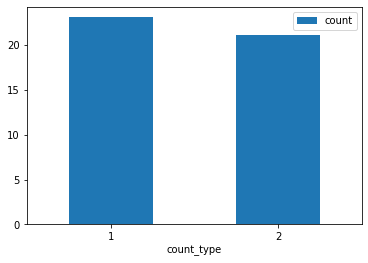

In [33]:
online_unique = online[['wordpair_id','clueFinal']].value_counts().reset_index().groupby(['wordpair_id']).size().reset_index(name='count1')
raw_unique = raw[['wordpair_id','Clue1']].value_counts().reset_index().groupby(['wordpair_id']).size().reset_index(name='count2')
raw_unique = raw_unique.merge(online_unique)
raw_long = pd.wide_to_long(raw_unique, stubnames='count', i=['wordpair_id'], j='count_type').reset_index()
display(raw_long.head())
count_means = raw_long[['wordpair_id','count_type', 'count']].groupby(['count_type']).mean().reset_index()
display(count_means)
ax = count_means.plot.bar(x='count_type', y='count', rot=0)
plt.savefig(os.path.join(plot_path, 'num_unique_clues_both_dataset.png'))

## Compare this between raw and online
- sim(clueFinal, t1) = x
- sim(clueFinal, t2) = y
- Assign the smaller of x or y to be the “closer” target
- Assign the greater of x or y to be the “farther” target
- Now calculate average similarity to “closer” vs. “farther"
- Do this by level to see if final clues are more skewed towards one of the targets


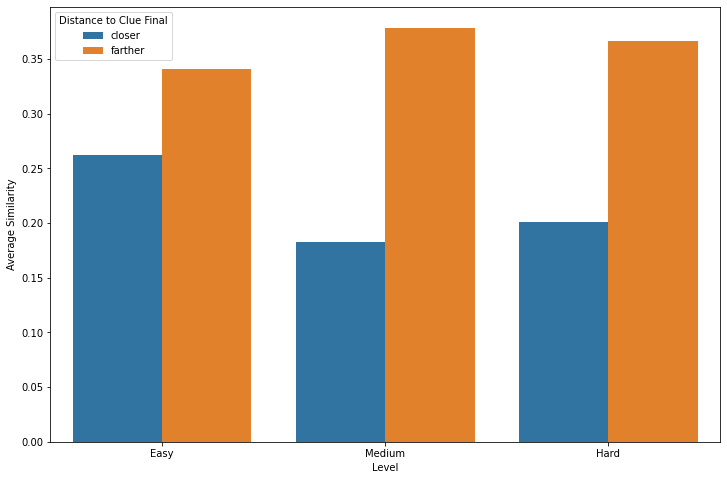

In [34]:
new_online = online[['clueFinal','target1', 'target2', 'Level', 'Ranking']]
for j in ['clueFinal', 'target1', 'target2']:
  new_online[f'{j}True'] = new_online[j].apply(lambda x: return_emb(x))
new_online = new_online.dropna().reset_index(drop = True)

x, y, closer, farther = [], [], [], []
for i in range(len(new_online)):
  xs = cosine_similarity(glove[new_online.loc[i, 'clueFinalTrue']], glove[new_online.loc[i, 'target1True']])
  ys = cosine_similarity(glove[new_online.loc[i, 'clueFinalTrue']], glove[new_online.loc[i, 'target2True']])

  x.append(xs)
  y.append(ys)

  if xs < ys:
    closer.append(xs)
    farther.append(ys)
  else:
    closer.append(ys)
    farther.append(xs)
new_online['x'] = x
new_online['y'] = y
new_online['closer'] = closer 
new_online['farther'] = farther
new_online_grouped = new_online[['Level', 'closer', 'farther']].groupby(['Level']).mean().reset_index().melt(id_vars = ['Level'])
new_online_grouped = new_online_grouped.rename({"value": 'Average Similarity', 'variable': 'Distance to Clue Final'}, axis = 1)
new_online_grouped['Ranking'] = new_online_grouped['Level'].apply(lambda x: rankings[x])
new_online_grouped = new_online_grouped.sort_values('Ranking')
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(data = new_online_grouped, x = 'Level', y = 'Average Similarity', hue = 'Distance to Clue Final', ax = ax)
plt.savefig(os.path.join(plot_path, 'distance_to_clue_final_similarity.png'))
plt.show()

## - We discuss the extent to which participants select the different candidates as the final clue and the accuracy when these candidates are chosen as the final clue. We also break this down by level/difficulty


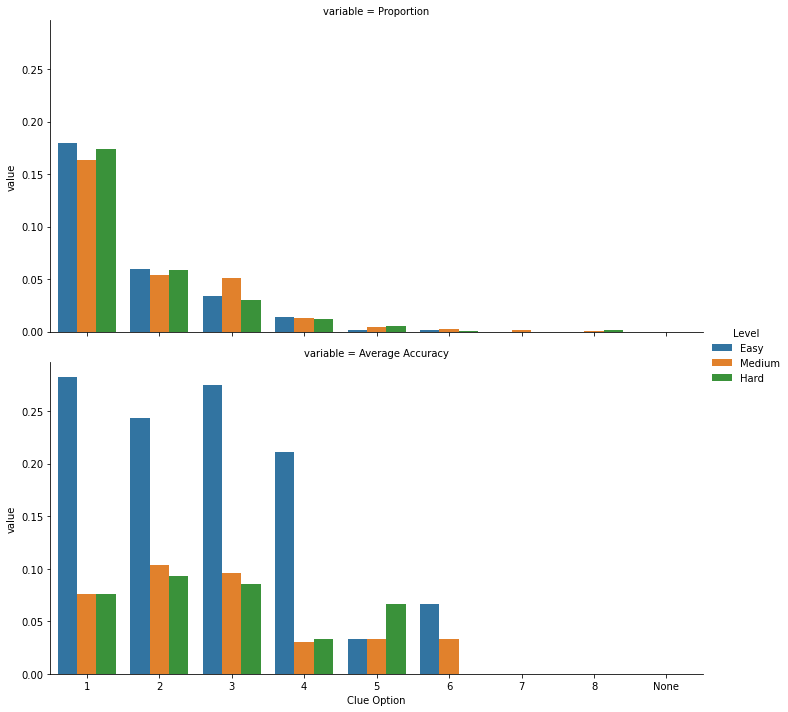

In [35]:
options = online[['wordpair_id', 'SelectedClue', 'Acc', 'Level']]
avg_acc_selected = options.groupby(['wordpair_id', 'SelectedClue']).mean().reset_index()
rows = []
for wp in options['wordpair_id'].unique():
  t = options[options['wordpair_id'] == wp].reset_index(drop = True)
  ## make sure to count "unique" clues as well, coded as 0 here, otherwise the count is 0 for them
  t[['SelectedClue']] = t[['SelectedClue']].fillna(value=0)
  t_counts = t[['wordpair_id', 'SelectedClue', 'Level']].value_counts().reset_index().ffill()
  t_counts[0] /= t_counts[0].sum() # get the proportions
  t_acc = t.groupby(['wordpair_id', 'SelectedClue', 'Level']).mean().reset_index().ffill()
  new_t = pd.merge(t_counts, t_acc, on = ['wordpair_id', 'SelectedClue', 'Level'])
  new_t = new_t.set_index(['wordpair_id', 'SelectedClue', 'Level'])

  idx = 3*(list(range(1, 10)))
  w = [wp for i in idx]
  diff = 9*['Easy'] + 9*['Medium'] + 9*['Hard']
  ind = zip(w, idx, diff)
  new_t = new_t.reindex(ind, fill_value=0).reset_index().ffill()
  new_t.loc[new_t['SelectedClue'] == 9, 'SelectedClue'] = 'None'
  rows.append(new_t)

final_options = pd.concat(rows, axis = 0, ignore_index=True).rename({0: 'Proportion', 'Acc': 'AvgAcc', 'SelectedClue': 'Clue Option'}, axis = 1)
final_options['Proportion'] = final_options['Proportion'].astype(float)
avg_final_options = final_options.groupby(['Clue Option', 'Level']).mean().reset_index().ffill()
avg_final_options['Ranking'] = avg_final_options['Level'].apply(lambda x: rankings[x])
avg_final_options = avg_final_options.sort_values(['Clue Option', 'Ranking']).rename({'AvgAcc': 'Average Accuracy'}, axis = 1).melt(id_vars = ['Clue Option', 'Level', 'Ranking'])

sns.catplot(x = 'Clue Option', y = 'value', hue = 'Level', row = 'variable', kind = 'bar', data = avg_final_options, aspect = 2)
plt.savefig(os.path.join(plot_path, 'proportion_avg_acc_per_level_per_clue.png'))
plt.show()

- If they are typing after search/threshold criterion is complete, then their first candidate time should be in the same ballpark as the original study clue time - plot histogram of RT for original data and online data.
  - Look at the TBOption1 (online) and Player1.RT (raw)
  - One hist overall and hist seperated by level

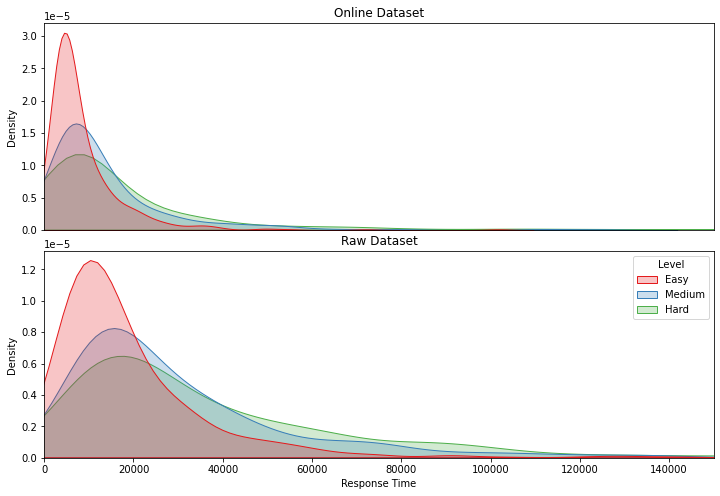

In [36]:
online_time = online[['TBOption1', 'Level']].rename({"TBOption1": 'Response Time'}, axis = 1)
online_time['Type'] = 'Online'
raw_time = pd.read_csv(raw_path, usecols = ['Player1.RT', 'Level']).rename({'Player1.RT': "Response Time"}, axis = 1)
raw_time['Type'] = 'Raw'

time_frame = pd.concat([online_time, raw_time], axis = 0, ignore_index = True)
fig, ax = plt.subplots(2, 1, figsize = (12, 8))
for i, t in enumerate(['Online', 'Raw']):
  tmp = time_frame[time_frame['Type'] == t]
  if i == 0:
    sns.kdeplot(data = tmp, x = 'Response Time', hue = 'Level', fill = True, ax = ax[i], legend = False, palette = 'Set1', hue_order = ['Easy', 'Medium', 'Hard'])
    ax[i].set_xticks([])
    ax[i].set_xlabel("")
  else:
    sns.kdeplot(data = tmp, x = 'Response Time', hue = 'Level', fill = True, ax = ax[i], legend = True, palette = 'Set1', hue_order = ["Easy", 'Medium', 'Hard'])
  ax[i].set_xlim([0, 150_000])
  ax[i].title.set_text(f"{t} Dataset")
plt.subplots_adjust(wspace = 0, hspace = 0.1)
plt.savefig(os.path.join(plot_path, 'density_estimation_between_datasets_per_level.png'))
plt.show()

- compute cosine similarity of each candidate clue to the targets - are first candidates more similar to the two targets than other candidates? do this using glove and swow both

In [14]:
options_names = [i for i in online.columns if 'clueoption' in i.lower()]
online_sim = online[options_names + ['target1', 'target2', 'wordpair_id', 'gameID']].melt(id_vars = ['target1', 'target2', 'wordpair_id', 'gameID']).dropna().reset_index(drop = True)
online_glove = online_sim.copy()
online_swow = online_sim.copy()

online_glove['target1'] = online_glove['target1'].apply(lambda x: return_emb(x))
online_glove['target2'] = online_glove['target2'].apply(lambda x: return_emb(x))
online_glove['value'] = online_glove['value'].apply(lambda x: return_emb(x))
online_glove = online_glove.dropna().reset_index(drop = True)
online_glove['sim_of_t1_val'] = [cosine_similarity(glove[online_glove.loc[i, 'target1']], glove[online_glove.loc[i, 'value']]) for i in range(len(online_glove))]
online_glove['sim_of_t2_val'] = [cosine_similarity(glove[online_glove.loc[i, 'target2']], glove[online_glove.loc[i, 'value']]) for i in range(len(online_glove))]
online_glove = online_glove.rename({'variable': 'clues'}, axis = 1)#.melt(id_vars = ['wordpair_id', 'gameID', 'clues', 'value'])
online_glove['embedding'] = 'glove'

online_swow['target1'] = online_swow['target1'].apply(lambda x: return_emb(x, 'swow'))
online_swow['target2'] = online_swow['target2'].apply(lambda x: return_emb(x, 'swow'))
online_swow['value'] = online_swow['value'].apply(lambda x: return_emb(x, 'swow'))
online_swow = online_swow.dropna().reset_index(drop = True)
online_swow['sim_of_t1_val'] = [cosine_similarity(swow[online_swow.loc[i, 'target1']], swow[online_swow.loc[i, 'value']]) for i in range(len(online_swow))]
online_swow['sim_of_t2_val'] = [cosine_similarity(swow[online_swow.loc[i, 'target2']], swow[online_swow.loc[i, 'value']]) for i in range(len(online_swow))]
online_swow = online_swow.rename({'variable': 'clues'}, axis = 1)#.melt(id_vars = ['wordpair_id', 'gameID', 'clues', 'value'])
online_swow['embedding'] = 'swow'

total_online_emb = pd.concat([online_glove, online_swow], axis = 0, ignore_index=True)
total_online_emb = total_online_emb.drop(['target1', 'target2', 'value'], axis = 1)
total_online_emb['clues'] = total_online_emb['clues'].apply(lambda x: x[-1])
total_online_emb = total_online_emb.melt(id_vars = ['wordpair_id', 'gameID', 'clues', 'embedding'])
total_online_emb['variable'] = total_online_emb['variable'].apply(lambda x: x.split('_')[2][-1])
total_online_emb.rename({'clues': 'Clue Option','variable': 'Target', 'embedding': 'Embedding', 'value': 'Similarity'}, axis = 1, inplace = True)

In [15]:
total_online_emb

,wordpair_id,gameID,Clue Option,Embedding,Target,Similarity
0,bowl-sun,454955-472987,1,glove,1,0.109829
1,cave-knight,454955-472987,1,glove,1,0.268687
2,glow-quick,454955-472987,1,glove,1,0.386934
3,gold-silver,454955-472987,1,glove,1,0.434517
4,oak-tree,454955-472987,1,glove,1,0.380577
...,...,...,...,...,...,...
17679,bowl-sun,473115-463794,8,swow,2,0.687335
17680,glow-quick,473115-463794,8,swow,2,0.120511
17681,gold-silver,473115-463794,8,swow,2,0.567042
17682,oak-tree,473115-463794,8,swow,2,0.667645


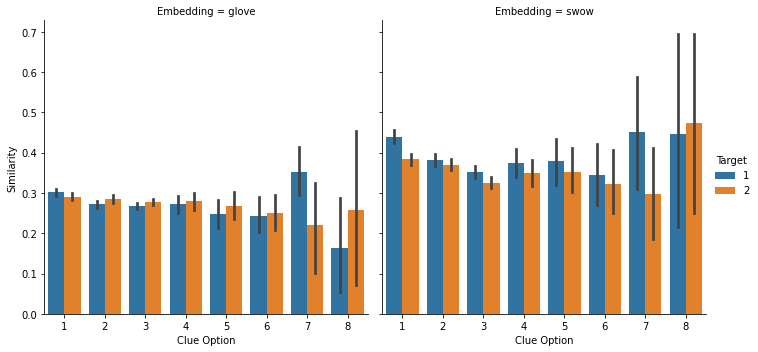

In [37]:
sns.catplot(data = total_online_emb, x = 'Clue Option', y = 'Similarity', hue = 'Target', col = 'Embedding', kind = 'bar')
plt.savefig(os.path.join(plot_path, 'similarity_per_target_per_embedding.png'))
plt.show()

## - Next, we evaluate whether the number of candidates produced by participants correlate with performance across different levels

,wordpair_id,gameID,clueOption1,clueOption2,clueOption3,clueOption4,clueOption5,clueOption6,clueOption7,clueOption8,clueFinal,Acc,Level,Ranking,Number of Clues
731,jump-leap,473184-487224,high,legs,quick,NaN,NaN,NaN,NaN,NaN,frog,1,Easy,1,3
729,gums-teeth,473184-487224,dentist,hygiene,flossing,NaN,NaN,NaN,NaN,NaN,dental,1,Easy,1,3
850,oak-tree,473749-473360,wood,earth,states,NaN,NaN,NaN,NaN,NaN,wood,1,Easy,1,3
849,new-old,473749-473360,time,measure,antonyms,NaN,NaN,NaN,NaN,NaN,time,1,Easy,1,3
848,lion-tiger,473749-473360,cat,animal,roar,NaN,NaN,NaN,NaN,NaN,cat,1,Easy,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,ankle-travel,464255-486078,cross up,basketball,walk,NaN,NaN,NaN,NaN,NaN,basketball,0,Hard,3,3
438,stern-wind,464103-465376,sailboat,strong,forceful,NaN,NaN,NaN,NaN,NaN,sailboat,1,Hard,3,3
436,regret-rude,464103-465376,actions,bad,past,NaN,NaN,NaN,NaN,NaN,bad,1,Hard,3,3
399,giant-subtle,463960-455649,nimble,noise,large,elephant,NaN,NaN,NaN,NaN,nimble,0,Hard,3,4


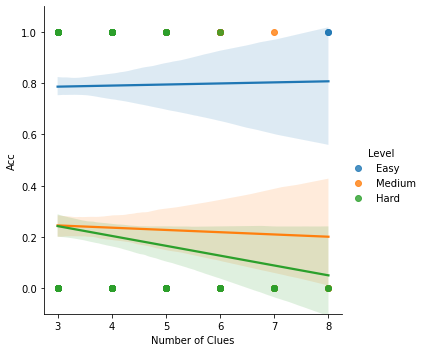

In [38]:
# perform regplot by level with Acc and number of clues per row
temp_online_clues = online_clues.sort_values(['Ranking'])
display(temp_online_clues)
sns.lmplot(data = temp_online_clues, x = 'Number of Clues', y = 'Acc', hue = 'Level')
plt.ylim([0-0.1, 1+0.1])
plt.savefig(os.path.join(plot_path, 'regression_acc_by_num_clues_per_level.png'))
plt.show()

## - We evaluate whether the responses show signatures of clustering and/or foraging typically found in semantic retrieval tasks. we use a patchy semantic space and ask whether the candidate responses show any evidence of transitions within and outside the patch, and whether these are related to correct responses from the listener. 

In [18]:
def _patch1(data = online):
  wpid = data['wordpair_id'].unique()
  rows = []
  for t in wpid:
    temp = online[online['wordpair_id'] == t].reset_index()
    temp = temp.loc[:, ['wordpair_id', 'clueOption1', 'target1', 'target2', 'Level', 'Acc', 'clueFinal', 'index']].reset_index(drop = True)
    row_frame = temp[['clueFinal', 'Acc', 'index', 'Level']]
    row_frame['wordpair_id'] = t
    row_frame['target1'] = temp.loc[0, 'target1']
    row_frame['target2'] = temp.loc[0, 'target2']
    clues = list(temp['clueOption1'].unique())
    row_frame['words_in_patch'] = ','.join(clues)
    row_frame['patchsize'] = len(clues)
    row_frame['Level'] = temp.loc[0, 'Level']

    rows.append(row_frame)

  frame = pd.concat(rows).reset_index(drop = True).rename({'index': 'row_id'}, axis = 1)
  return frame

def _patch2(p1, source = 'glove'):
  if source == 'glove':
    source_emb = glove
  else:
    source_emb = swow
  frame = p1.copy().drop('words_in_patch', axis = 1)
  rows = []
  wpid = frame['wordpair_id'].unique()
  for r in tqdm(wpid):
    d = frame[frame['wordpair_id'] == r].reset_index()
    avg_vector = np.mean(np.c_[source_emb[d.loc[0,'target1']], source_emb[d.loc[0, 'target2']]], axis = 1)
    words_frame = pd.DataFrame.from_dict([{'word': w, 'sim': cosine_similarity(source_emb[w], avg_vector)} for w in glove.columns.to_list()])
    words_frame = words_frame.sort_values('sim', ascending = False)[~words_frame['word'].isin([d.loc[0,'target1'], d.loc[0, 'target2']])].head(d.loc[0, 'patchsize'])
    patch_words = ','.join(words_frame['word'])
    row = {'wordpair_id': r, 'words_in_patch': patch_words}
    rows.append(row)
  dat = pd.DataFrame.from_dict(rows)
  frame = frame.merge(dat, on = 'wordpair_id', how = 'outer')
  return frame

def _movement(words):
  first, second = words
  if first[1] == 1 and second[1] == 1:
    return 'In-In'
  elif first[1] == 1 and second[1] == 0:
    return 'In-Out'
  elif first[1] == 0 and second[1] == 1:
    return 'Out-In'
  else:
    return 'Out-Out'

def _determine_movement(patch_data, typ):
  temp_options = online[['wordpair_id', 'clueOption1', 'clueOption2', 'clueOption3','clueOption4', 'clueOption5', 'clueOption6', 'clueOption7', 'clueOption8', 'clueFinal', 'Acc']]
  temp_options = temp_options.reset_index().rename({'index': 'row_id'}, axis = 1)
  rows = []
  for i in tqdm(range(len(temp_options))):
    r = {}
    row = temp_options.loc[i, :].dropna()
    r['wordpair_id'] = row.wordpair_id
    r['In-In'] = 0
    r['In-Out'] = 0
    r['Out-In'] = 0
    r['Out-Out'] = 0

    words = list(row.drop(['wordpair_id', 'Acc', 'clueFinal']).to_list())
    words = [w for w in words if isinstance(w, str)]
    patch_wordpair = patch_data.loc[patch_data['wordpair_id'] == row.wordpair_id, :]
    words_in_patch = [(w, 1) if w in patch_wordpair['words_in_patch'].to_list()[0].split(',') else (w, 0) for w in words ]
    perms = [(words_in_patch[i], words_in_patch[i+1]) for i in range(0, len(words_in_patch)-1)]
    movements = pd.Series([_movement(p) for p in perms])
    ps = pd.DataFrame(movements.value_counts().reset_index()).rename({'index': 'Type', 0: 'Count'}, axis = 1)

    ps_d = dict(zip(ps['Type'], ps['Count']))
    for k, v in ps_d.items():
      r[k] = v
    r['Acc'] = row.Acc
    r['ClueFinal'] = row.clueFinal
    r['row_id'] = row.row_id
    rows.append(r)
    
  total = pd.DataFrame.from_dict(rows)
  total['PatchMethod'] = typ
  return total

def _join_data(p1, p2, p3 = None):
  join_cols = ['wordpair_id', 'target1', 'target2', 'patchsize', 'Level', 'clueFinal', 'Acc', 'row_id']
  if p3 is not None:
    interp_data = pd.merge(p1, p2, on = join_cols, suffixes = ('_num_unique', '_glove'))
    joined_data = pd.merge(interp_data, p3, on = join_cols).rename({'words_in_patch': 'words_in_patch_swow'}, axis = 1)
  else:
    joined_data = pd.merge(p1, p2, on = join_cols, suffixes=('_num_unique', '_glove'))

  for typ in ['glove', 'swow']:
    sim_word_name = f'Similar Words ({typ})'
    joined_data[sim_word_name] = [','.join(list(set(joined_data.loc[i, 'words_in_patch_num_unique'].split(',')) &  set(joined_data.loc[i, f'words_in_patch_{typ}'].split(',')))).strip() for i in range(len(joined_data))]
    joined_data[f'Similar Words Size ({typ})'] = joined_data[sim_word_name].apply(lambda x: len(x.split(',')) if ',' in x else 0)
    joined_data[f'Dissimilar Words ({typ})'] = [','.join(list((Counter(joined_data.loc[i, 'words_in_patch_num_unique'].split(',')) - Counter(joined_data.loc[i, f'words_in_patch_{typ}'].split(','))).elements())) for i in range(len(joined_data))]
    joined_data[f'Dissimilar Words Size ({typ})'] = joined_data[f'Dissimilar Words ({typ})'].apply(lambda x: len(x.split(',')) if ',' in x else 0)
    joined_data[f'Overlap Similarity ({typ})'] = [joined_data.loc[i, f'Similar Words Size ({typ})'] / joined_data.loc[i, 'patchsize'] for i in range(len(joined_data))]
  return joined_data

In [19]:
patch1 = _patch1()
patch2_glove = _patch2(patch1, source = 'glove')
patch2_swow = _patch2(patch1, source = 'swow')
movement1 = _determine_movement(patch1, 'NumberOfUniqueClues')
movement2_glove = _determine_movement(patch2_glove, 'TopNByAvgVectorGloveEmbeddings')
movement2_swow = _determine_movement(patch2_swow, 'TopNByAvgVectorSWOWEmbeddings')
total = pd.concat([movement1, movement2_glove, movement2_swow], axis =0, ignore_index=True)
joined_data = _join_data(patch1, patch2_glove, patch2_swow)

100%|██████████| 1456/1456 [00:05<00:00, 249.56it/s]


In [20]:
#write out joined data and total to csv
joined_data.to_csv(r"/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/Processed/joined_patch_movement.csv", index = False)
total.to_csv(r"/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/Processed/total_patch_movement.csv", index = False)

- Patches are defined using user-generated data and average vector method, correlation is reported

In [21]:
from scipy.stats import pearsonr, spearmanr
corr, _ = pearsonr(patch1['Acc'], patch1['patchsize'])
print('Pearsons correlation: %.3f' % corr)
corr, _ = spearmanr(patch1['Acc'], patch1['patchsize'])
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: -0.444
Spearmans correlation: -0.414


  - Patch size vs. accuracy relationship reported

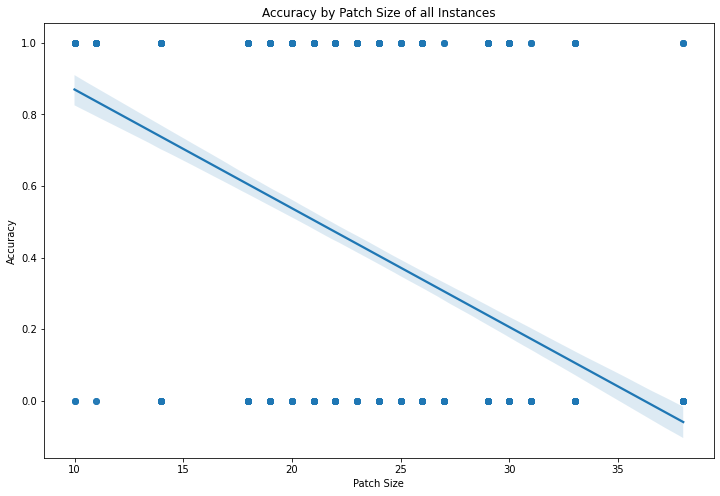

In [39]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.regplot(data = joined_data[['Acc', 'patchsize']], x = 'patchsize', y = 'Acc', ax = ax)
plt.xlabel("Patch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy by Patch Size of all Instances")
plt.savefig(os.path.join(plot_path, 'regression_acc_by_patchsize.png'))
plt.show()

  - Proportion of transitions reported

,PatchMethod,Movement,Amount of Movement
0,NumberOfUniqueClues,In-In,0.333696
1,NumberOfUniqueClues,In-Out,0.377753
2,NumberOfUniqueClues,Out-In,0.112224
3,NumberOfUniqueClues,Out-Out,0.176327
4,TopNByAvgVectorGloveEmbeddings,In-In,0.035190
5,TopNByAvgVectorGloveEmbeddings,In-Out,0.137626
6,TopNByAvgVectorGloveEmbeddings,Out-In,0.117050
7,TopNByAvgVectorGloveEmbeddings,Out-Out,0.710134
8,TopNByAvgVectorSWOWEmbeddings,In-In,0.065416
9,TopNByAvgVectorSWOWEmbeddings,In-Out,0.194621


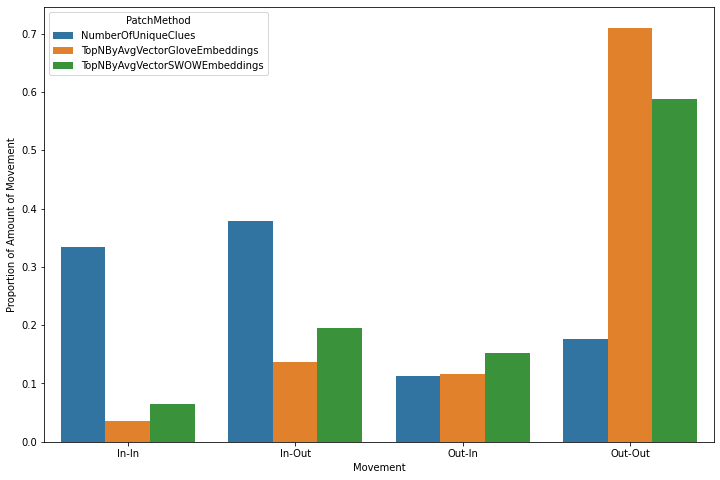

In [40]:
p = total.merge(online[['wordpair_id', 'AvgAcc']], on = 'wordpair_id')
p = p.melt(id_vars = ['wordpair_id', 'ClueFinal', 'AvgAcc', 'Acc', 'PatchMethod', 'row_id']).drop_duplicates().reset_index(drop = True)
p = p.rename({'variable': 'Movement', 'value': 'Amount of Movement', 'AvgAcc': 'Average Accuracy at Wordpair'}, axis = 1)
tp = p[['wordpair_id', 'Movement', 'Amount of Movement', 'PatchMethod']].groupby(['PatchMethod','wordpair_id', 'Movement']).agg({'Amount of Movement': 'sum'})
tp = tp.groupby(level=[0,1]).apply(lambda x: x / x.sum()).reset_index()
tp = tp.groupby(['PatchMethod', 'Movement']).mean().reset_index()
display(tp)

fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(data = tp, x = 'Movement', y = 'Amount of Movement', hue = 'PatchMethod', ax = ax)
plt.ylabel('Proportion of Amount of Movement')
plt.savefig(os.path.join(plot_path, 'barplot_movement_patchmethod.png'))
plt.show()

 - Accuracy as a function of number of transitions of each type reported

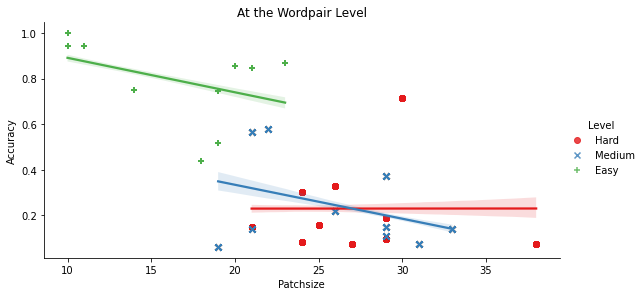

In [41]:
fixed_patch1 = patch1.drop(['clueFinal', 'Acc'], axis = 1).reset_index(drop = True)[['wordpair_id', 'Level', 'patchsize']]
avg_wp = online[['wordpair_id', 'Level', 'Acc']].groupby(['wordpair_id', 'Level']).mean().reset_index()
total_g = fixed_patch1.merge(avg_wp, on = ['wordpair_id', 'Level']).sort_values(['wordpair_id', 'Level'], ascending = [True, False]).reset_index(drop = True)
sns.lmplot(x = 'patchsize', y = 'Acc', hue = 'Level', data = total_g, size = 4, aspect = 2, palette='Set1', markers = ['o', 'x', '+'])
plt.ylabel('Accuracy')
plt.xlabel('Patchsize')
plt.title('At the Wordpair Level')
plt.savefig(os.path.join(plot_path, "regression_acc_by_patchsize_per_level_at_wordpair.png"))
plt.show()

 - Compute similarity between successive responses
  - Sim of ClueOption1 to ClueOption2, Cluetopion2 to clueoption3
  - Do this over the Level
  - Lineplot for overall average
  - write out to a .csv file

In [25]:
succ_clues = []
for sourc in ['glove', 'swow']:
  if sourc == 'glove':
    source_emb = glove
  else:
    source_emb = swow

  for i in tqdm(range(len(online_clues))):
    row_dict = {}
    row = dict(online_clues.loc[i, :].dropna())
    row_dict['Level'] = row['Level']
    row_dict['Source'] = sourc
    for j in range(1, 8):
      curr = f"clueOption{j}"
      next = f"clueOption{j+1}"
      if next in row:
        curr_emb_word = return_emb(row[curr])
        next_emb_word = return_emb(row[next])
        if not isinstance(curr_emb_word, float) and not isinstance(next_emb_word, float):
          sim = cosine_similarity(source_emb[curr_emb_word], source_emb[next_emb_word])
        else:
          sim = np.NaN
      else:
        sim = np.NaN
      move = f"{j}->{j+1}"
      row_dict[move] = sim
      
    succ_clues.append(row_dict)

succession = pd.DataFrame.from_dict(succ_clues)
succession = succession.melt(id_vars = ['Level', 'Source']).rename({'variable': "Movement", "value": "Similarity"}, axis = 1)

100%|██████████| 1456/1456 [00:00<00:00, 1462.87it/s]


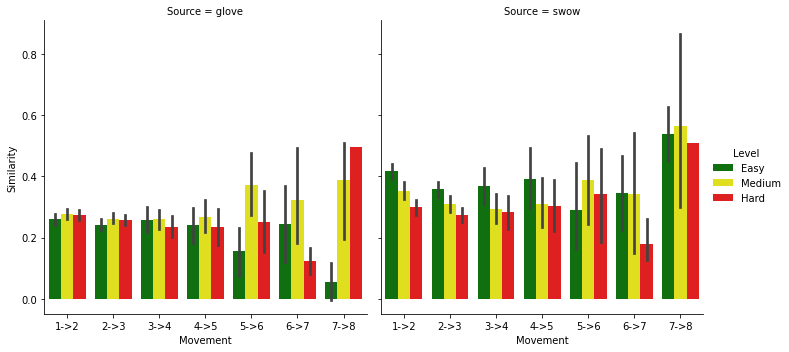

In [42]:
# plot again with standard error maybe change to barplot
sns.catplot(data = succession, x = 'Movement', y = 'Similarity', hue = 'Level', col = 'Source',
             hue_order = ['Easy', 'Medium', 'Hard'], kind = 'bar', palette = ['green', 'yellow', 'red'])
plt.savefig(os.path.join(plot_path, "barplot_similarity_per_level_per_emebedding_given_movement.png"))
plt.show()

  - Compute adjusted ratio of clustering
    - https://rdrr.io/github/ggreeley/MemoryOrg/man/ARC_correct.html
    - for this, we need a dataframe that records 1 or 0 for each clue candidate being an “in” or “out” transition in separate columns for example for the wordpair “quick-glow” we have the candidates “lighter, match, fire” then we need 3 columns signifying whether lighter was an in/out transition, match was in/out, and fire was in/out then we can compute the ARC


In [27]:
patches = joined_data[['wordpair_id', 'words_in_patch_num_unique', 'words_in_patch_glove', 'words_in_patch_swow']].drop_duplicates().reset_index(drop = True)
patch_clues = online_clues.merge(patches, on = 'wordpair_id')
records = []
for i in tqdm(range(len(patch_clues))):
  row = patch_clues.loc[i, :].dropna()
  patches = {'num_unique': row.words_in_patch_num_unique.split(','), 
             'glove': row.words_in_patch_glove.split(','), 
             'swow': row.words_in_patch_swow.split(',')
  }
  co = list(map(lambda x: 'clueOption' + str(x), range(1, 9)))
  
  for typ, p in patches.items():
    for c in co:
      record = {}
      record['wordpair_id'] = row.wordpair_id
      record['gameID'] = row.gameID
      record['clueOption'] = c[-1]
      record['Method'] = typ

      if c in row.index.to_list():
        record['clueOption_word'] = row[c]
        if row[c] in p:
          record["In/Out"] = 'In'
          records.append(record)
        else:
          record[f"In/Out"] = 'Out'
          records.append(record)
      else:
        record['clueOption_word'] = np.NaN
        record["In/Out"] = np.NaN
        records.append(record)
total_records = pd.DataFrame.from_dict(records)[['wordpair_id', 'gameID', 'clueOption', 'clueOption_word', 'Method', 'In/Out']]
total_records = total_records.sort_values(['wordpair_id', 'gameID', 'clueOption', 'Method'])
total_records.to_csv("/content/drive/MyDrive/Classes/Fall 2021/Word Embeddings Project (Connector)/Data/Processed/arc_data.csv", index = False)

100%|██████████| 1456/1456 [00:01<00:00, 936.14it/s]


In [28]:
# add in gameID and all of clue options
total_records

,wordpair_id,gameID,clueOption,clueOption_word,Method,In/Out
6656,ankle-travel,455383-451866,1,run,glove,Out
6648,ankle-travel,455383-451866,1,run,num_unique,In
6664,ankle-travel,455383-451866,1,run,swow,Out
6657,ankle-travel,455383-451866,2,dance,glove,Out
6649,ankle-travel,455383-451866,2,dance,num_unique,Out
...,...,...,...,...,...,...
34926,trauma-weird,491095-486542,7,NaN,num_unique,NaN
34942,trauma-weird,491095-486542,7,NaN,swow,NaN
34935,trauma-weird,491095-486542,8,NaN,glove,NaN
34927,trauma-weird,491095-486542,8,NaN,num_unique,NaN
